In [1]:
!pip install -r requirements.txt

In [2]:
import kagglehub
# path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
path = kagglehub.dataset_download("jangedoo/utkface-new")

/home/e20240011884/Documents/M2/Image, sécurité et deep learning/face_filters/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 331M/331M [00:16<00:00, 21.0MB/s] 

Extracting files...


In [3]:
import cv2
import os

In [4]:
# Load face detection classifier
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [5]:
latent_dim = 128
image_size = 128
images = []

In [6]:
# # This takes like 8 minutes


i = 0
# Preprocess images
for root, dirs, files in os.walk(path):
    for file in files:
        if i >= 13000:
            break
        
        if file.endswith(".jpg"):
            i+=1
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)

            # Handle case where image could not be loaded
            if img is None:
                print(f"Warning: Could not load image {img_path}. Skipping.")
                continue

            # Convert to grey for face detection
            grey_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Call classifier on image to detect faces of any size
            face = face_classifier.detectMultiScale(
                grey_img, scaleFactor=1.1 , minNeighbors=5 , minSize=(40,40)
            )

            # Process and append images only if faces are detected
            if len(face) > 0:
                # Iterate through all detected faces (or pick the first one)
                for (x, y, w, h) in face:
                    x_max = x+w
                    y_max = y+h
                    # Ensure crop coordinates are within image bounds
                    x = max(0, x)
                    y = max(0, y)
                    x_max = min(img.shape[1], x_max)
                    y_max = min(img.shape[0], y_max)

                    if w > 0 and h > 0: # Ensure valid crop dimensions
                        im_cropped = img[y:y_max , x:x_max]

                        # Ensure im_cropped is not empty after cropping
                        if im_cropped.size == 0:
                            print(f"Warning: Empty crop for {img_path}. Skipping.")
                            continue

                        im_cropped = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2RGB)
                        im_cropped = cv2.resize(im_cropped, (image_size, image_size))
                        im_cropped = im_cropped.astype("float32") / 255.0
                        images.append(im_cropped)

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

images = np.array(images)
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

print("Training shape:", x_train.shape)
print("Test shape:", x_test.shape)

Training shape: (6100, 128, 128, 3)
Test shape: (1525, 128, 128, 3)


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input

2025-11-24 09:45:40.727311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-24 09:45:42.708645: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 09:45:44.085008: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-24 09:46:00.840334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [9]:

encoder_inputs = keras.Input(shape=(128, 128, 3))

x = layers.Conv2D(16, 3, strides=2, padding="same", activation="relu")(encoder_inputs)
x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)


def sampling(args):
    mean, log_var = args
    epsilon = tf.random.normal(shape=tf.shape(mean))
    return mean + tf.exp(0.5 * log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


2025-11-24 09:46:19.260412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-11-24 09:46:19.332112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/e20240011884/Documents/M2/Image, sécurité et deep learning/face_filters/.venv/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12/lib64
2025-11-24 09:46:19.332128: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU dev

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   448         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   4640        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d_1[0][0]']         

In [10]:
decoder_inputs = Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 128, activation="relu")(decoder_inputs)
x = layers.Reshape((8, 8, 128))(x)

# UpSampling + Conv blocks (reduce checkerboard / mejora detalles)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(32, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(16, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

# Salida final en [0,1] usando sigmoid (más directo para MAE/MSE)
decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
decoder = Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_3 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                             

In [11]:
beta = 0.001

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, x):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x, training=True)
            reconstruction = self.decoder(z, training=True)  # ya está en [0,1] por sigmoid

            # Reconstruction losses: MAE + SSIM
            mae = tf.reduce_mean(tf.abs(x - reconstruction), axis=[1,2,3])  # per-sample
            ssim = tf.clip_by_value(tf.image.ssim(x, reconstruction, max_val=1.0), 0.0, 1.0)
            ssim_loss = 1.0 - ssim  # per-sample
            recon_loss = mae + 0.5 * ssim_loss
            recon_loss = tf.reduce_mean(recon_loss)  # scalar

            # KL divergence
            kl_loss = -0.5 * tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            )
            kl_loss = tf.reduce_mean(kl_loss)

            total_loss = recon_loss + beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {"loss": total_loss,
                "reconstruction_loss": recon_loss,
                "kl_loss": kl_loss}

    def call(self, x):
        _, _, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction

In [12]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [13]:
class SaveEvery10(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            print(f"\n🔽 Saving VAE on epoch {epoch+1}...")
            vae.encoder.save(f"vae_encoder_epoch_{epoch+1}.keras")
            vae.decoder.save(f"vae_decoder_epoch_{epoch+1}.keras")
            vae.save_weights(f"vae_weights_epoch_{epoch+1}.weights.h5")

In [14]:
# Train the vae
epochs = 100
batch_size = 128

vae.fit(
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test, None),
    callbacks=[SaveEvery10()]
)

vae.encoder.save('vae_encoder.keras')
vae.decoder.save('vae_decoder.keras')

vae.save_weights('vae_weights.weights.h5')

Epoch 1/100
48/48 [==============================] - 31s 614ms/step - loss: 0.4276 - reconstruction_loss: 0.4173 - kl_loss: 10.2485 - val_loss: 0.0000e+00
Epoch 2/100
48/48 [==============================] - 29s 612ms/step - loss: 0.3520 - reconstruction_loss: 0.3336 - kl_loss: 13.6593 - val_loss: 0.0000e+00
Epoch 3/100
48/48 [==============================] - 30s 619ms/step - loss: 0.3235 - reconstruction_loss: 0.3144 - kl_loss: 16.1542 - val_loss: 0.0000e+00
Epoch 4/100
48/48 [==============================] - 29s 609ms/step - loss: 0.3194 - reconstruction_loss: 0.3021 - kl_loss: 18.2490 - val_loss: 0.0000e+00
Epoch 5/100
48/48 [==============================] - 30s 614ms/step - loss: 0.2991 - reconstruction_loss: 0.2903 - kl_loss: 20.7934 - val_loss: 0.0000e+00
Epoch 6/100
48/48 [==============================] - 30s 625ms/step - loss: 0.2953 - reconstruction_loss: 0.2808 - kl_loss: 22.7944 - val_loss: 0.0000e+00
Epoch 7/100
48/48 [==============================] - 30s 614ms/step - 

In [15]:
encoder = tf.keras.models.load_model("vae_encoder.keras", compile=False)
decoder = tf.keras.models.load_model("vae_decoder.keras", compile=False)

vae = VAE(encoder, decoder)

vae.build((None,) + x_train.shape[1:])
vae.load_weights("vae_weights.weights.h5")

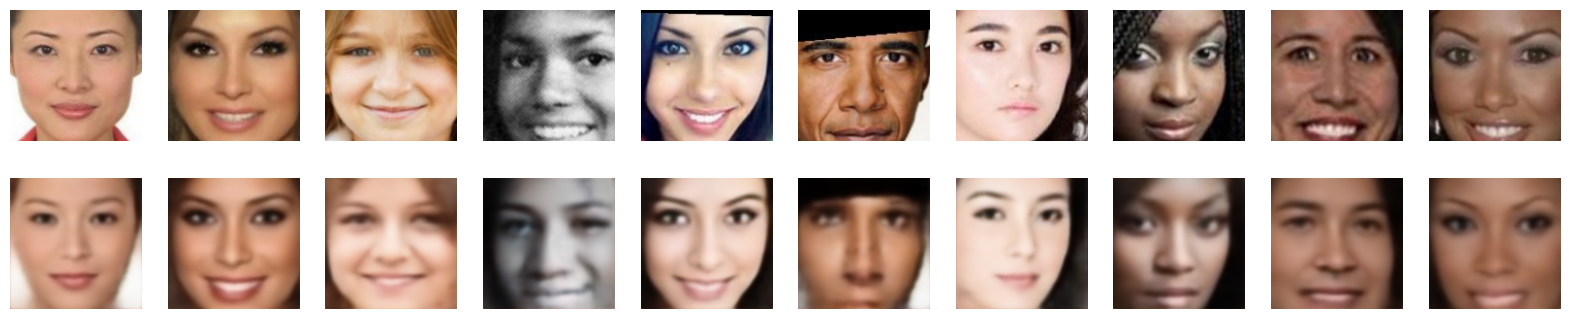

In [ ]:
# Compare original and reconstructed images
import matplotlib.pyplot as plt

n = 10

# El encoder devuelve: z_mean, z_log_var, z
z_mean, z_log_var, z = vae.encoder(x_test[:n])
decoded_imgs = vae.decoder(z)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.axis("off")

plt.show()

In [ ]:
loss = vae.history.history['loss']
epoch_range = range(epochs)

plt.plot(epoch_range, loss, label='Training Loss')

TypeError: 'NoneType' object is not subscriptable